In [33]:
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

In [24]:
class ImagePairDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = T.Compose([
            T.Resize((264, 264)),  # Cambiar tamaño de redimensionado a 264x264
            T.ToTensor()
        ])
        self.image_pairs = self.load_image_pairs()

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        image1_path, image2_path, label = self.image_pairs[idx]
        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        image1 = self.transform(image1)
        image2 = self.transform(image2)
        return image1, image2, torch.tensor(label, dtype=torch.float32)

    def load_image_pairs(self):
        image_pairs = []
        similar_dir = os.path.join(self.root_dir, "OK")
        dissimilar_dir = os.path.join(self.root_dir, "NOK")
        
        similar_images = [os.path.join(similar_dir, f) for f in os.listdir(similar_dir) if f.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff'))]
        dissimilar_images = [os.path.join(dissimilar_dir, f) for f in os.listdir(dissimilar_dir) if f.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff'))]
        
        # Crear pares de imágenes similares con etiqueta 0
        for i in range(len(similar_images) // 2):
            image1_path = similar_images[i]
            image2_path = similar_images[len(similar_images) - i - 1]
            image_pairs.append((image1_path, image2_path, 0))
        
        # Crear pares de imágenes disímiles con etiqueta 1
        for i in range(min(len(similar_images), len(dissimilar_images))):
            image1_path = similar_images[i]
            image2_path = dissimilar_images[i]
            image_pairs.append((image1_path, image2_path, 1))

        return image_pairs

In [25]:
dataset = ImagePairDataset("/home/aacastro/Alejandro/DQ_ACA_2024/C/data/full_dataset")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Conv2d(3, 256, kernel_size=11, stride=4)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(3, stride=2)
        self.cnn2 = nn.Conv2d(256, 256, kernel_size=5, stride=1)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        self.cnn3 = nn.Conv2d(256, 384, kernel_size=3, stride=1)
        
        # Calcular el tamaño de la entrada para fc1
        self.flatten_size = self._get_flatten_size()
        
        self.fc1 = nn.Linear(self.flatten_size, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 264, 264)
            x = self.cnn1(x)
            x = self.relu(x)
            x = self.maxpool1(x)
            x = self.cnn2(x)
            x = self.relu(x)
            x = self.maxpool2(x)
            x = self.cnn3(x)
            x = self.relu(x)
            return x.view(1, -1).size(1)

    def forward_once(self, x):
        x = self.cnn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.relu(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [27]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

Epoch number 0
 Current loss 2.872607946395874

Epoch number 0
 Current loss 2.325735569000244

Epoch number 0
 Current loss 1.948106050491333

Epoch number 0
 Current loss 2.1171352863311768

Epoch number 0
 Current loss 1.8407715559005737

Epoch number 0
 Current loss 1.6506714820861816

Epoch number 1
 Current loss 1.6899350881576538

Epoch number 1
 Current loss 1.8426076173782349

Epoch number 1
 Current loss 1.6373096704483032

Epoch number 1
 Current loss 1.638236165046692

Epoch number 1
 Current loss 1.8951693773269653

Epoch number 1
 Current loss 1.6324422359466553

Epoch number 2
 Current loss 1.9453237056732178

Epoch number 2
 Current loss 1.5778899192810059

Epoch number 2
 Current loss 1.7344895601272583

Epoch number 2
 Current loss 1.7400683164596558

Epoch number 2
 Current loss 1.757541537284851

Epoch number 2
 Current loss 1.6077933311462402

Epoch number 3
 Current loss 1.635331630706787

Epoch number 3
 Current loss 1.5656485557556152

Epoch number 3
 Current lo

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


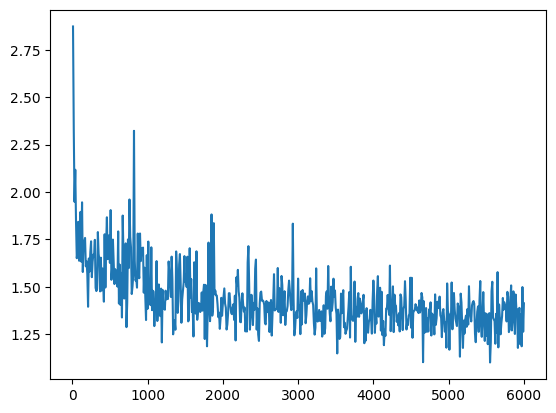

In [28]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration_number = 0

for epoch in range(100):
    for i, (img0, img1, label) in enumerate(train_loader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

def show_plot(iteration, loss):
    import matplotlib.pyplot as plt
    plt.plot(iteration, loss)
    plt.show()

show_plot(counter, loss_history)

In [34]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

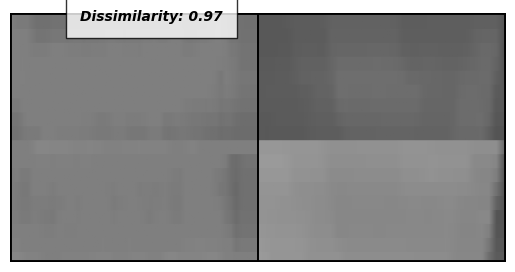

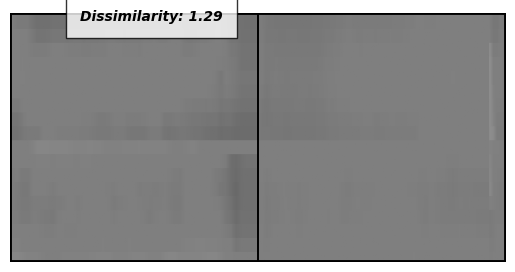

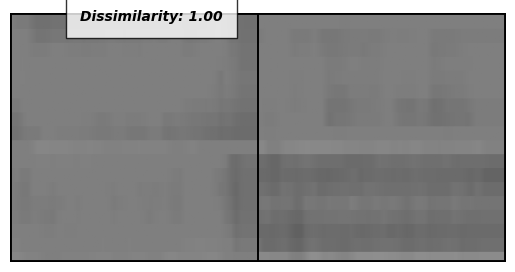

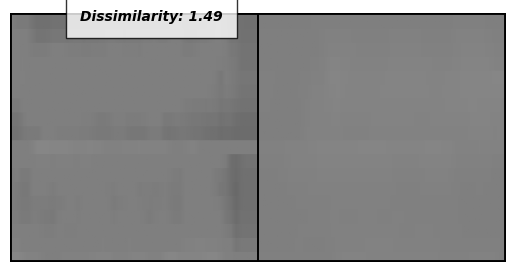

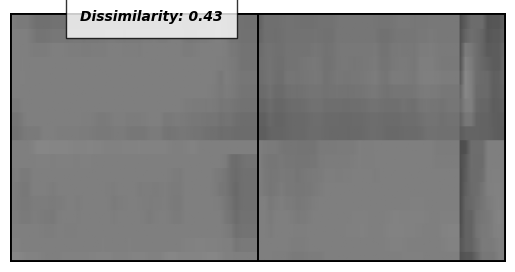

In [35]:
test_loader_one = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataiter = iter(test_loader_one)
x0, _, _ = next(dataiter)

for i in range(5):
    try:
        # Iterate over 5 images and test them with the first image (x0)
        _, x1, label2 = next(dataiter)

        # Concatenate the two images together for visualization
        concatenated = torch.cat((x0, x1), 0)
        
        # Pass the images through the network
        output1, output2 = net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        # Show the images and the dissimilarity score
        imshow(torchvision.utils.make_grid(concatenated.cpu()), f'Dissimilarity: {euclidean_distance.item():.2f}')
    except StopIteration:
        break